In [1]:
# Change working directory
import os
# TODO: Specify your path here
new_directory = "./"
os.chdir(new_directory)
print("Current Working Directory:", os.getcwd())

Current Working Directory: /Users/me/Tmp/ETH/DL/dl_proj


In [2]:
# imports
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from models.networks import get_model
from data_utils.data_stats import *

import matplotlib.pyplot as plt

In [3]:
dataset = 'cifar10'                 # One of cifar10, cifar100, stl10, imagenet or imagenet21
architecture = 'B_6-Wi_512'
data_resolution = 32                # Resolution of data as it is stored
crop_resolution = 64                # Resolution of fine-tuned model (64 for all models we provide)
num_classes = CLASS_DICT[dataset]
#data_path = './beton/'
eval_batch_size = 512
checkpoint = 'in21k_cifar10'        # This means you want the network pre-trained on ImageNet21k and finetuned on CIFAR10

In [4]:
# TODO: Do not forget to choose GPU as runtime
torch.backends.cuda.matmul.allow_tf32 = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# TODO: Create a folder called 'checkpoints'. It is already included in the .gitignore file
# Define the model and specify the pre-trained weights
model = get_model(architecture=architecture, resolution=crop_resolution, num_classes=num_classes, checkpoint=checkpoint)
# model.cuda()

Weights already downloaded
Load_state output <All keys matched successfully>


In [5]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2471, 0.2435, 0.2616)

transform = transforms.Compose([
    transforms.Resize((crop_resolution, crop_resolution)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

cifar10_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(cifar10_dataset, batch_size=1000, shuffle=True)


cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

tensor([[[0.3137, 0.3137, 0.3137,  ..., 0.3137, 0.3020, 0.2941],
         [0.3176, 0.3176, 0.3216,  ..., 0.3137, 0.3020, 0.2941],
         [0.3216, 0.3255, 0.3333,  ..., 0.3176, 0.3059, 0.2980],
         ...,
         [0.5804, 0.5961, 0.6314,  ..., 0.5804, 0.5490, 0.5333],
         [0.5686, 0.5765, 0.5961,  ..., 0.5765, 0.5137, 0.4824],
         [0.5647, 0.5686, 0.5765,  ..., 0.5725, 0.4980, 0.4588]],

        [[0.2431, 0.2431, 0.2431,  ..., 0.2471, 0.2353, 0.2275],
         [0.2471, 0.2471, 0.2510,  ..., 0.2510, 0.2353, 0.2275],
         [0.2510, 0.2549, 0.2627,  ..., 0.2549, 0.2353, 0.2275],
         ...,
         [0.5373, 0.5569, 0.5961,  ..., 0.5255, 0.4784, 0.4549],
         [0.5255, 0.5373, 0.5608,  ..., 0.5137, 0.4353, 0.3961],
         [0.5216, 0.5294, 0.5451,  ..., 0.5059, 0.4157, 0.3686]],

        [[0.1529, 0.1529, 0.1569,  ..., 0.1451, 0.1255, 0.1176],
         [0.1529, 0.1569, 0.1608,  ..., 0.1451, 0.1255, 0.1176],
         [0.1569, 0.1608, 0.1725,  ..., 0.1490, 0.1294, 0.

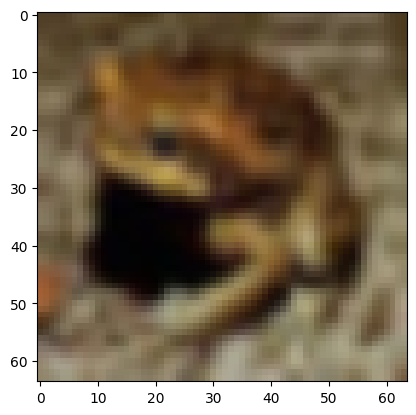

In [8]:
# select test image
image_nr = 300

# display image
image, true_label = cifar10_dataset[image_nr]
print(image)
print(image.shape)
image = image.numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.show()

# prepare image to be processed by model
image, _ = cifar10_dataset[image_nr]
image = image.unsqueeze(0)
image = image.view(-1)
# image = image.cuda()

In [ ]:
model.eval()

with torch.no_grad():
    output = model(image)
    print("Shape of the output tensor:", output.shape)

probabilities = torch.nn.functional.softmax(output, dim=0)
predicted_class = torch.argmax(probabilities).item()

predicted_label = cifar10_classes[predicted_class]
tr_label = cifar10_classes[true_label]

print(f"Model prediction:", predicted_label)
print(f"True label:      ", tr_label)

In [ ]:
from torchinfo import summary

summary(model)

In [ ]:
model

In [ ]:
model.blocks[-1].block[2]

In [ ]:
torch.softmax(output, dim=-1)

In [ ]:
from grad_cam.grad_cam import GradCAM
from grad_cam.utils.model_targets import ClassifierOutputTarget, ClassifierOutputSoftmaxTarget, SoftmaxOutputTarget
from grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

target_layers = [model.blocks[-1].block[2]]
input_image = torch.unsqueeze(image, dim=0)
print(input_image.shape)
input_tensor = input_image # Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

# targets = None

# both ClassifierOutputTarget and ClassifierOutputSoftmaxTarget are 2D, so we cannot use them
targets = [SoftmaxOutputTarget()]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

In [39]:
from torchvision import models
resnet_model = models.resnet50(pretrained=True)

/Users/me/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/me/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:
resnet_model.layer4[-1].bn3

BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

[[[0.         0.         0.         ... 0.03274241 0.03274241 0.03274241]
  [0.         0.         0.         ... 0.03274241 0.03274241 0.03274241]
  [0.         0.         0.         ... 0.03274241 0.03274241 0.03274241]
  ...
  [0.9999999  0.9999999  0.9999999  ... 0.7598579  0.7598579  0.7598579 ]
  [0.9999999  0.9999999  0.9999999  ... 0.7598579  0.7598579  0.7598579 ]
  [0.9999999  0.9999999  0.9999999  ... 0.7598579  0.7598579  0.7598579 ]]]
(64, 64)


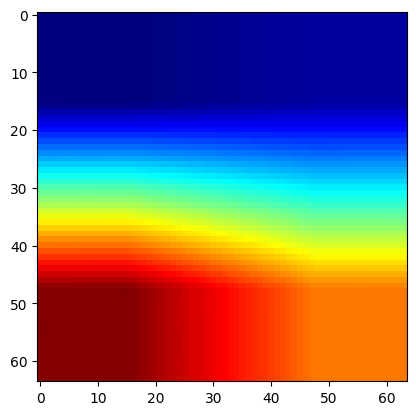

In [42]:
from grad_cam.utils.image import (
    show_cam_on_image, deprocess_image, preprocess_image
)
from grad_cam import (
    GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus,
    AblationCAM, XGradCAM, EigenCAM, EigenGradCAM,
    LayerCAM, FullGrad, GradCAMElementWise
)
target_layers = [resnet_model.layer4[-1].bn3]
rgb_img, _ = cifar10_dataset[image_nr]
rgb_img = rgb_img.numpy().transpose((1, 2, 0))
# rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])

output = resnet_model(input_tensor)

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category (for every member in the batch) will be used.
# You can target specific categories by
# targets = [e.g ClassifierOutputTarget(281)]
targets = None

# Using the with statement ensures the context is freed, and you can
# recreate different CAM objects in a loop.
cam_algorithm = GradCAM
with cam_algorithm(model=resnet_model,
                   target_layers=target_layers,
                   use_cuda=False) as cam:


    # AblationCAM and ScoreCAM have batched implementations.
    # You can override the internal batch size for faster computation.
    cam.batch_size = 32
    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets)
    print(grayscale_cam)

    grayscale_cam = grayscale_cam[0, :]
    print(grayscale_cam.shape)
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    plt.imshow(cam_image)
    plt.show()

In [ ]:
# from https://github.com/liguge/1D-Grad-CAM-for-interpretable-intelligent-fault-diagnosis/blob/main/Grad-CAM%2B%2B%201d.py

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

def target_category_loss(x, category_index, nb_classes):
    return torch.mul(x, F.one_hot(category_index, nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (torch.sqrt(torch.mean(torch.square(x))) + 1e-5)

def resize_1d(array, shape):
    res = np.zeros(shape)
    if array.shape[0] >= shape:
        ratio = array.shape[0]/shape
        for i in range(array.shape[0]):
            res[int(i/ratio)] += array[i]*(1-(i/ratio-int(i/ratio)))
            if int(i/ratio) != shape-1:
                res[int(i/ratio)+1] += array[i]*(i/ratio-int(i/ratio))
            else:
                res[int(i/ratio)] += array[i]*(i/ratio-int(i/ratio))
        res = res[::-1]
        array = array[::-1]
        for i in range(array.shape[0]):
            res[int(i/ratio)] += array[i]*(1-(i/ratio-int(i/ratio)))
            if int(i/ratio) != shape-1:
                res[int(i/ratio)+1] += array[i]*(i/ratio-int(i/ratio))
            else:
                res[int(i/ratio)] += array[i]*(i/ratio-int(i/ratio))
        res = res[::-1]/(2*ratio)
        array = array[::-1]
    else:
        ratio = shape/array.shape[0]
        left = 0
        right = 1
        for i in range(shape):
            if left < int(i/ratio):
                left += 1
                right += 1
            if right > array.shape[0]-1:
                res[i] += array[left]
            else:
                res[i] += array[right] * \
                    (i - left * ratio)/ratio+array[left]*(right*ratio-i)/ratio
        res = res[::-1]
        array = array[::-1]
        left = 0
        right = 1
        for i in range(shape):
            if left < int(i/ratio):
                left += 1
                right += 1
            if right > array.shape[0]-1:
                res[i] += array[left]
            else:
                res[i] += array[right] * \
                    (i - left * ratio)/ratio+array[left]*(right*ratio-i)/ratio
        res = res[::-1]/2
        array = array[::-1]
    return res

class ActivationsAndGradients:
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = []
        self.activations = []

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations.append(output)

    def save_gradient(self, module, grad_input, grad_output):
        # Gradients are computed in reverse order
        self.gradients = [grad_output[0]] + self.gradients

    def __call__(self, x):
        self.gradients = []
        self.activations = []
        return self.model(x)


class BaseCAM:
    def __init__(self, model, target_layer, use_cuda=False):
        self.model = model.eval()
        self.target_layer = target_layer
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.activations_and_grads = ActivationsAndGradients(self.model, target_layer)

    def forward(self, input_img):
        return self.model(input_img)

    def get_cam_weights(self,
                        input_tensor,
                        target_category,
                        activations,
                        grads):
        raise Exception("Not Implemented")

    def get_loss(self, output, target_category):
        print(output.size())
        return output[target_category]

    def __call__(self, input_tensor, target_category=None):
        if self.cuda:
            input_tensor = input_tensor.cuda()

        output = self.activations_and_grads(input_tensor)

        if target_category is None:
            output = output.squeeze()
            target_category = np.argmax(output.cpu().data.numpy())
            print(output)
            print(target_category)
        self.model.zero_grad()
        loss = self.get_loss(output, target_category)
        loss.backward(retain_graph=True)

        activations = self.activations_and_grads.activations[-1].cpu().data.numpy()
        grads = self.activations_and_grads.gradients[-1].cpu().data.numpy()
        #weights = np.mean(grads, axis=(0))
        weights = self.get_cam_weights(input_tensor, target_category, activations, grads)
        # cam = np.zeros(activations.shape[1:], dtype=np.float32)
        #
        # for i, w in enumerate(weights):
        #     cam += w * activations[i, :]
        # cam = activations.dot(weights)
        cam = activations.T.dot(weights)    #maybe better
        # print(input_tensor.shape[1])
        # print(cam.shape)
        # x = np.arange(0, 247, 1)
        # plt.plot(x, cam.reshape(-1, 1))
        # sns.set()
        # ax = sns.heatmap(cam.reshape(-1, 1).T)
        #cam = cv2.resize(cam, input_tensor.shape[1:][::-1])
        cam = resize_1d(cam, (12288))
        #cam = np.maximum(cam, 0)
        # cam = np.expand_dims(cam, axis=1)
        # ax = sns.heatmap(cam)
        # plt.show()
        # cam = cam - np.min(cam)
        # cam = cam / np.max(cam)
        heatmap = (cam - np.min(cam)) / (np.max(cam) - np.min(cam) + 1e-10)
        print(heatmap.shape)
        return heatmap
class GradCAM(BaseCAM):
    def __init__(self, model, target_layer, use_cuda=False):
        super(GradCAM, self).__init__(model, target_layer, use_cuda)

    def get_cam_weights(self, input_tensor,
                        target_category,
                        activations,
                        grads):
        grads_power_2 = grads ** 2
        grads_power_3 = grads_power_2 * grads
        sum_activations = np.sum(activations)
        eps = 0.000001
        aij = grads_power_2 / (2 * grads_power_2 + sum_activations * grads_power_3 + eps)
        aij = np.where(grads != 0, aij, 0)

        weights = np.maximum(grads, 0) * aij
        weights = np.sum(weights)
        return weights
# from pytorch_grad_cam.utils.image import preprocess_image
target_layer = model.blocks[-1].block[2]

net = GradCAM(model, target_layer)

input_tensor = image
print(image.shape)
output = net(input_tensor)
print(output)
output_image = torch.tensor(output).view(3, 64, 64).numpy()
output_image = output_image.transpose((1, 2, 0))
plt.imshow(output_image)
plt.show()

In [83]:
from cifar10_models.resnet import *

model = resnet18()
weights = torch.load('state_dicts/resnet18.pt')
model.load_state_dict(weights)

ModuleNotFoundError: No module named 'cifar10_models'

sensitivity output width: 30
image number: 300


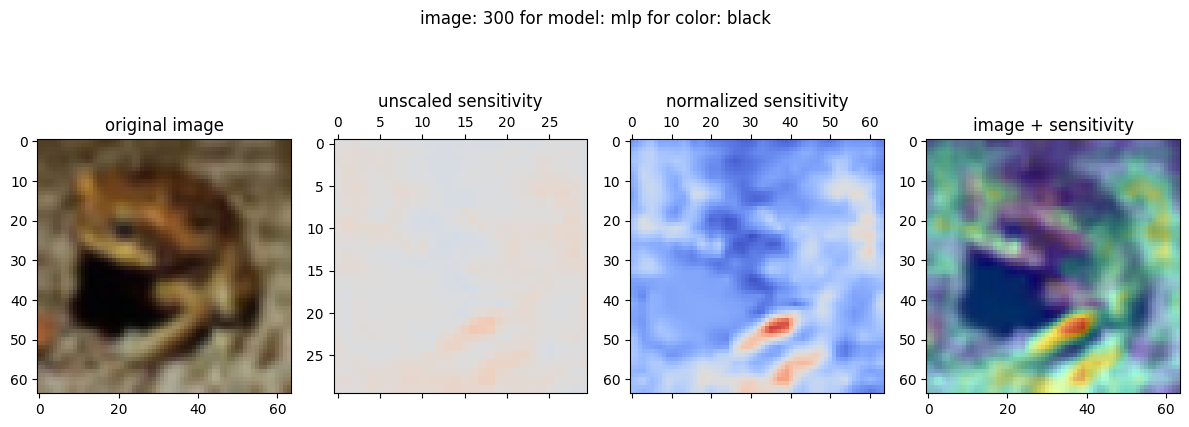

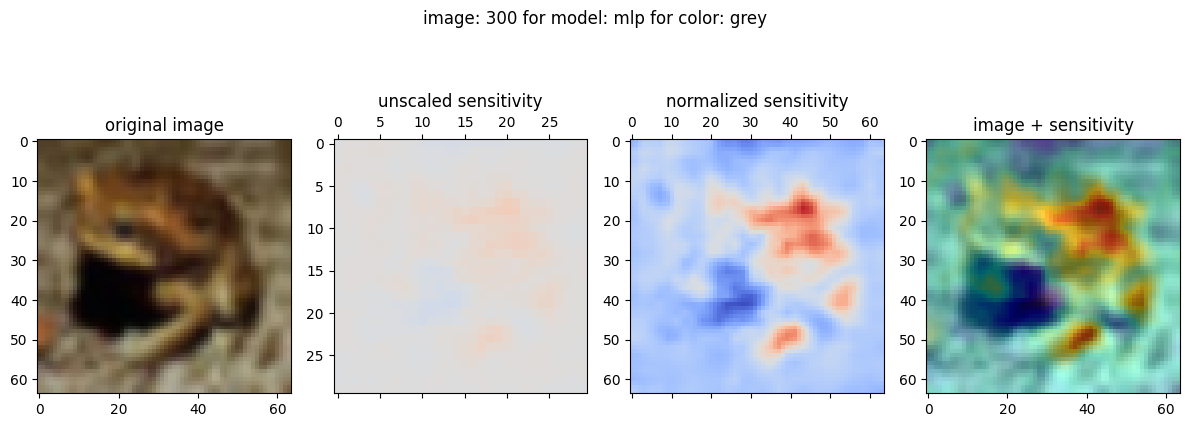

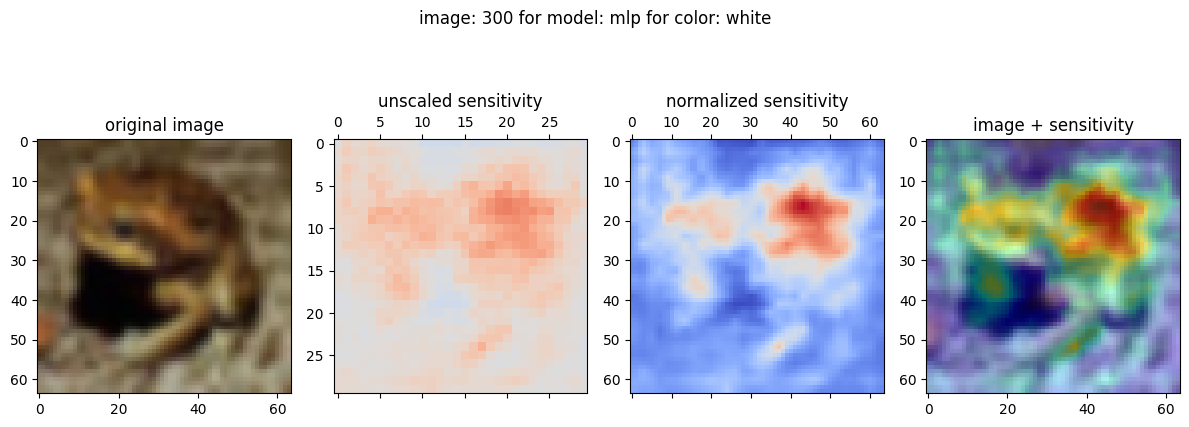

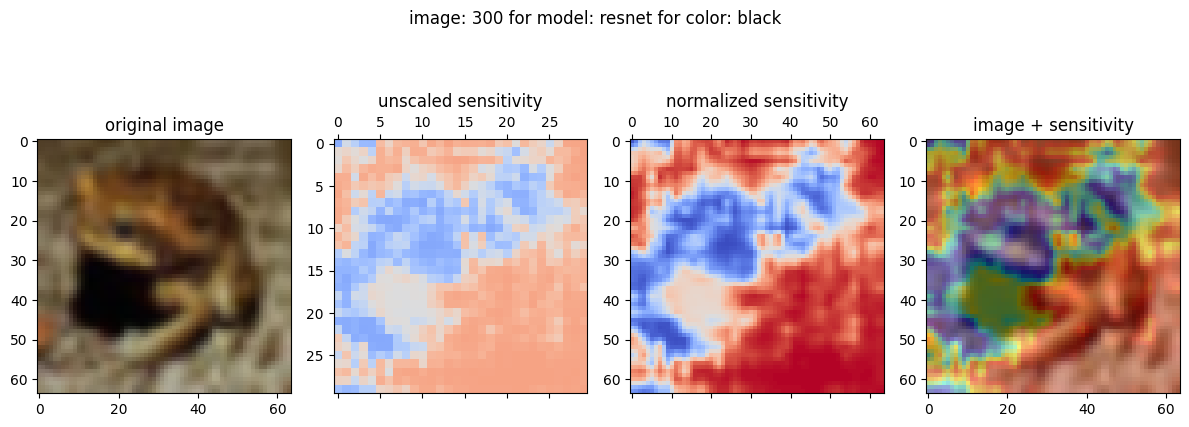

image number: 301


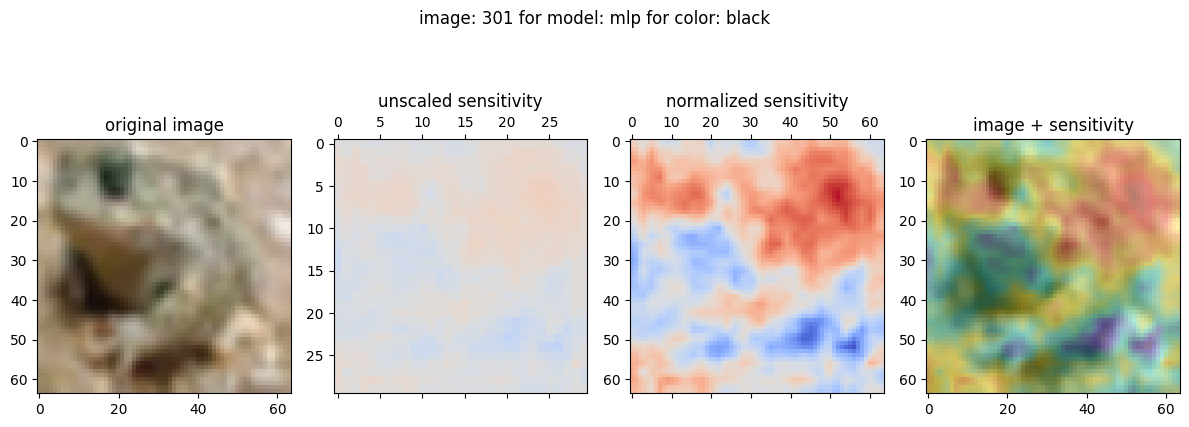

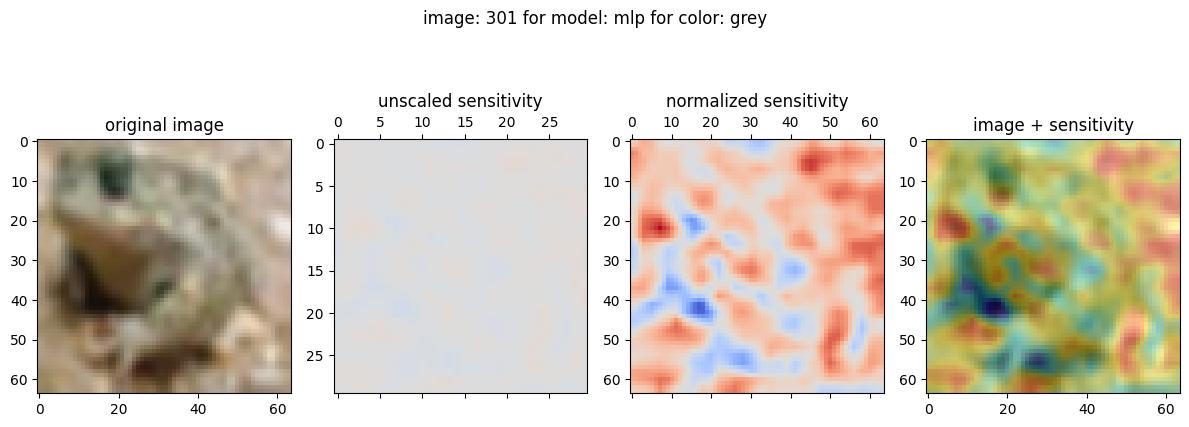

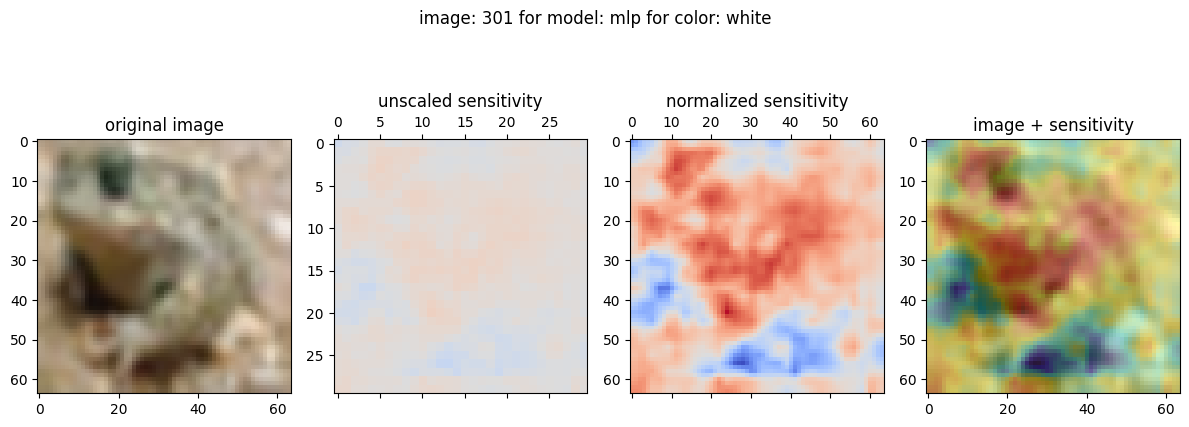

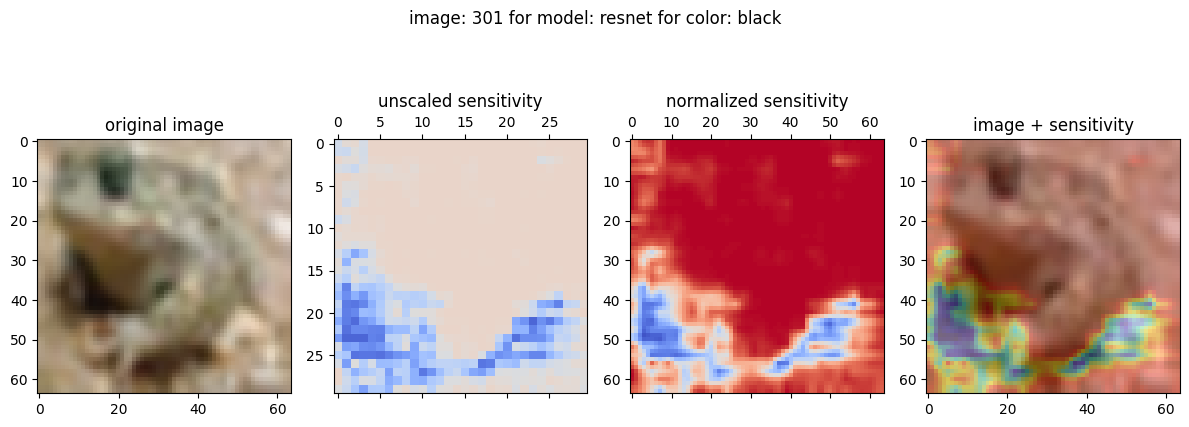

image number: 302


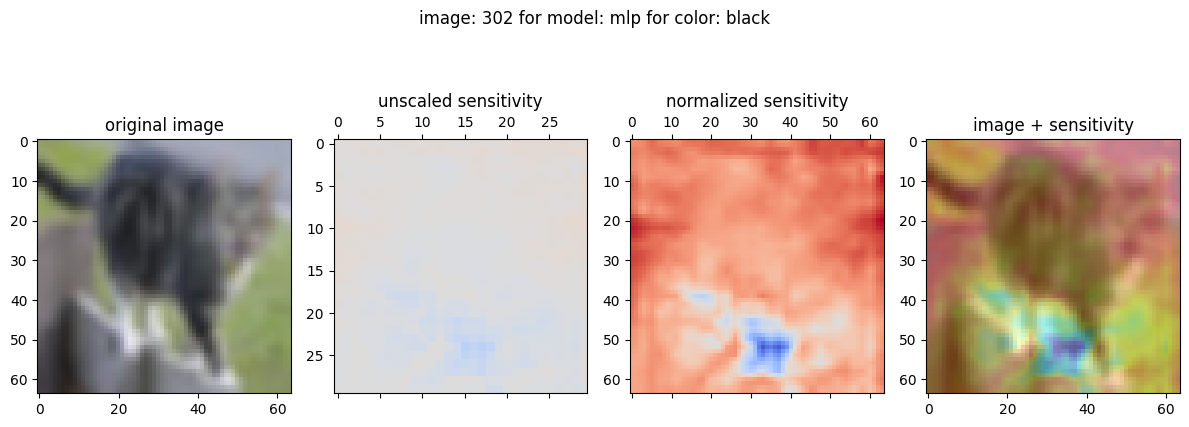

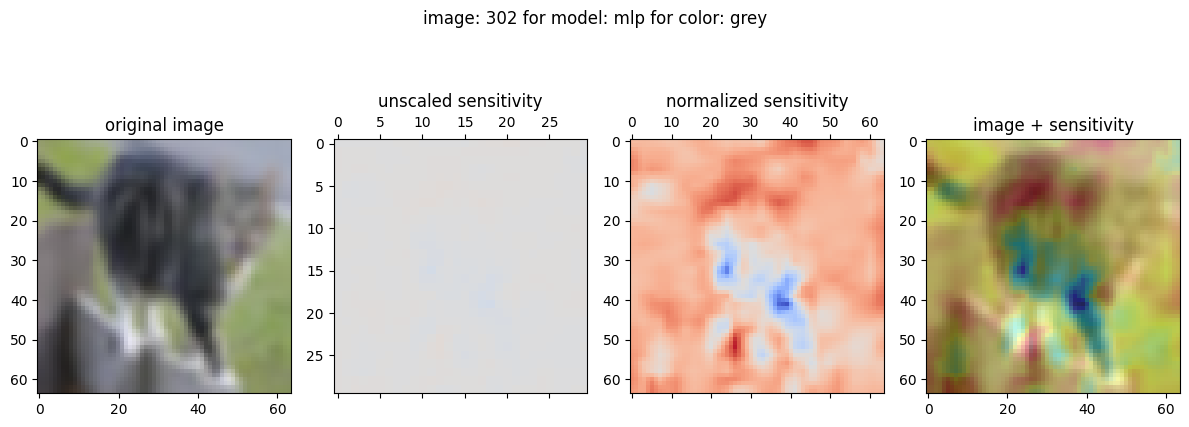

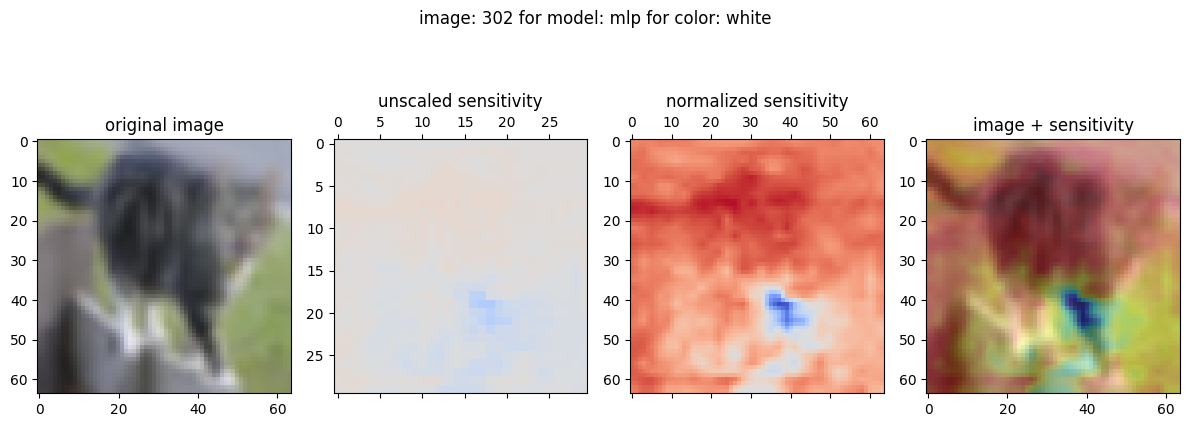

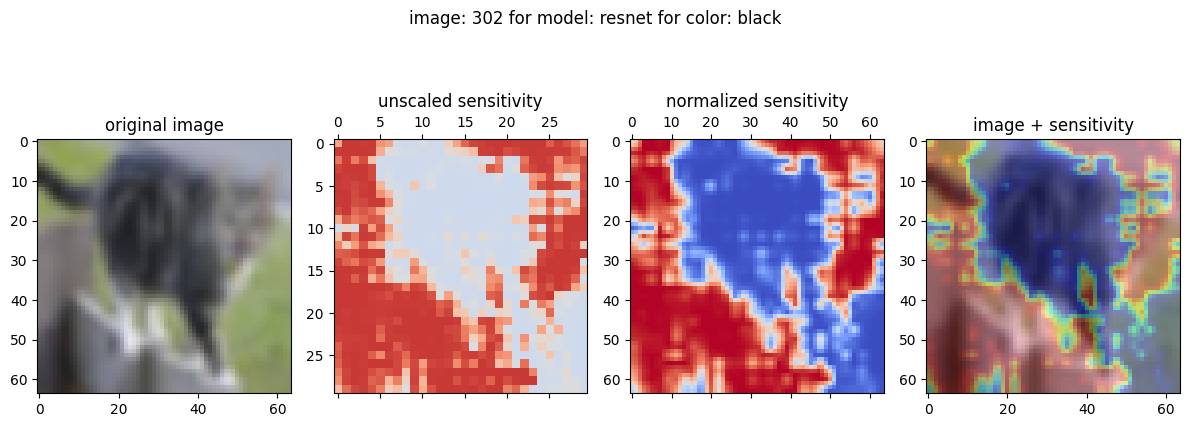

image number: 303


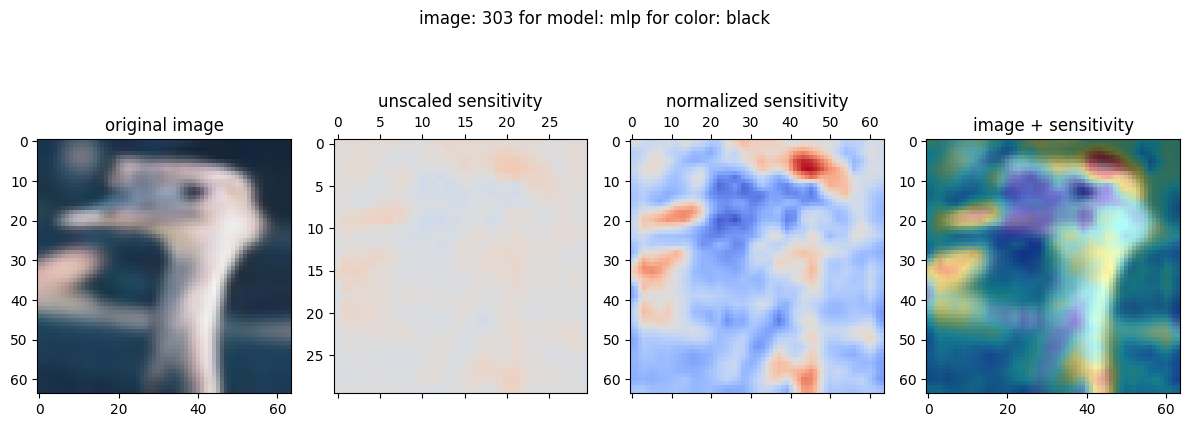

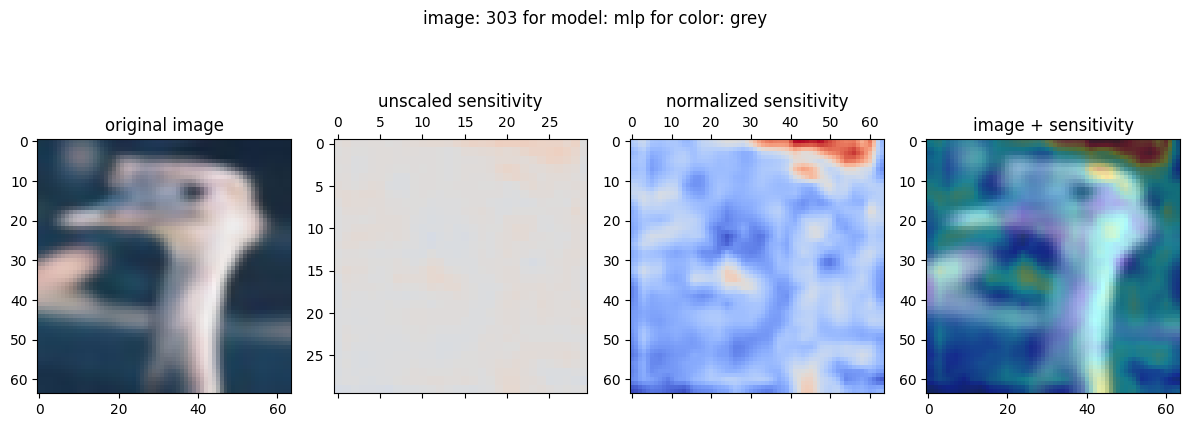

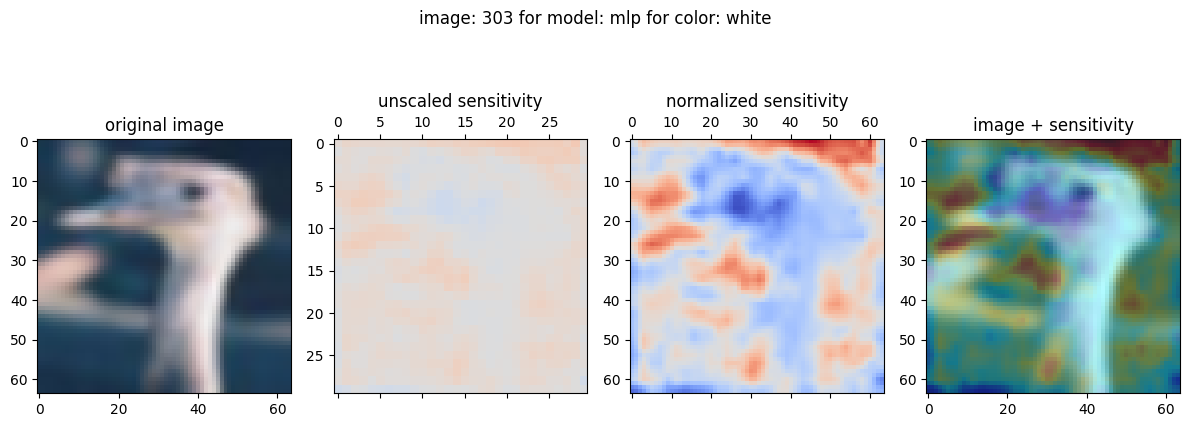

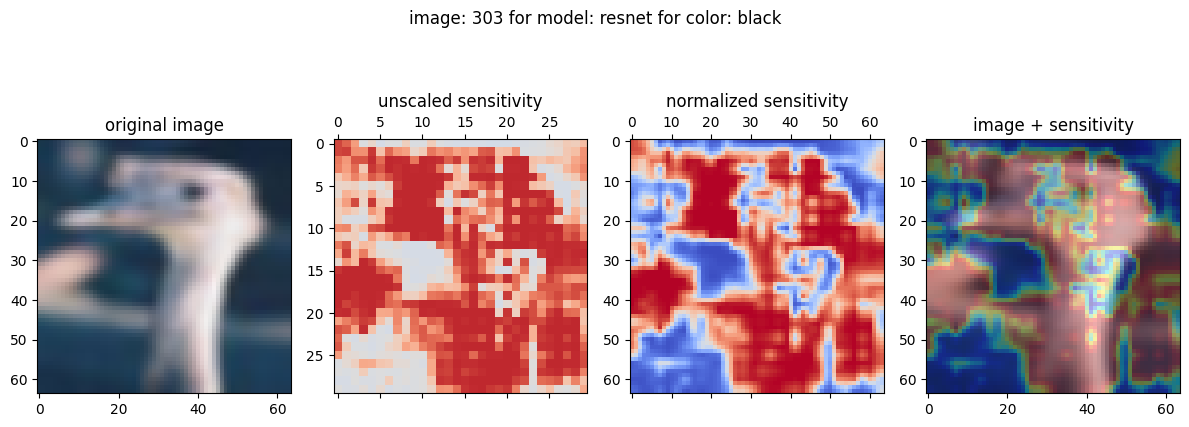

image number: 304


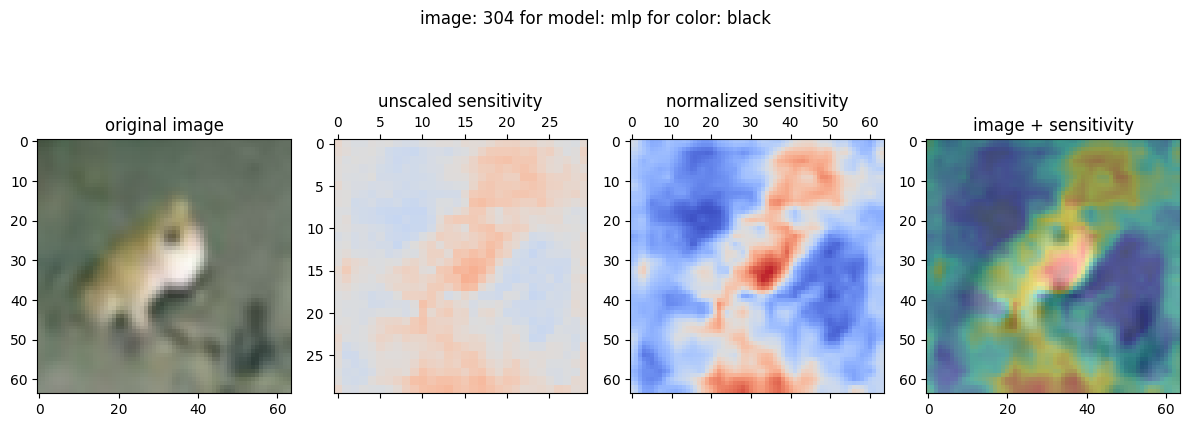

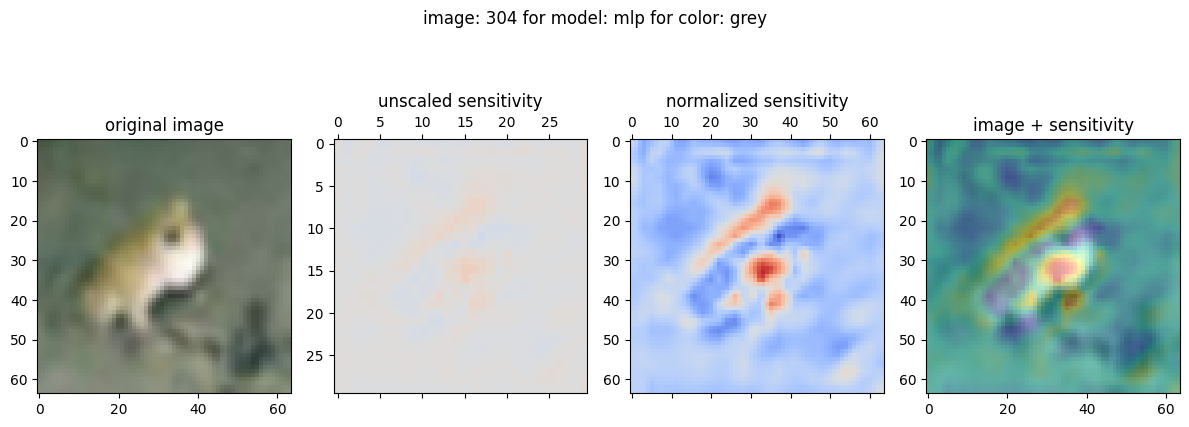

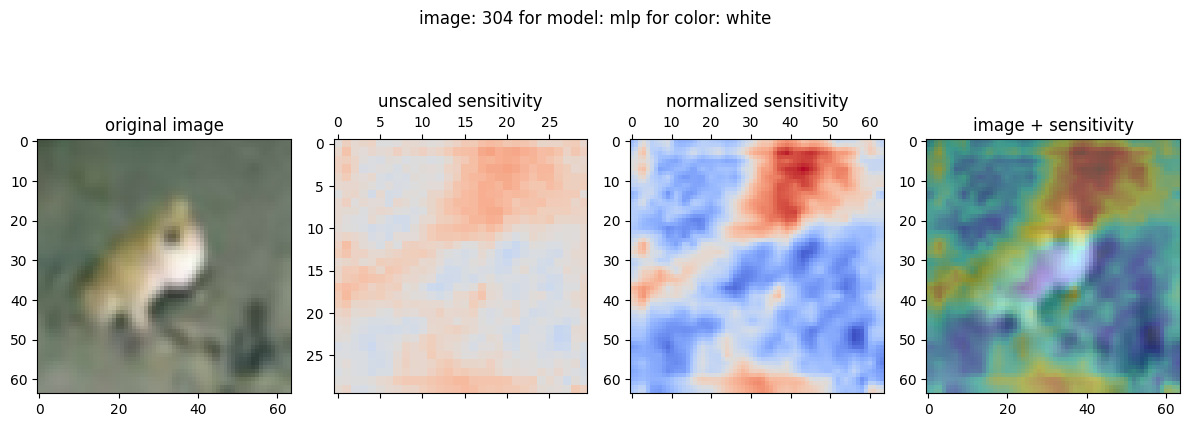

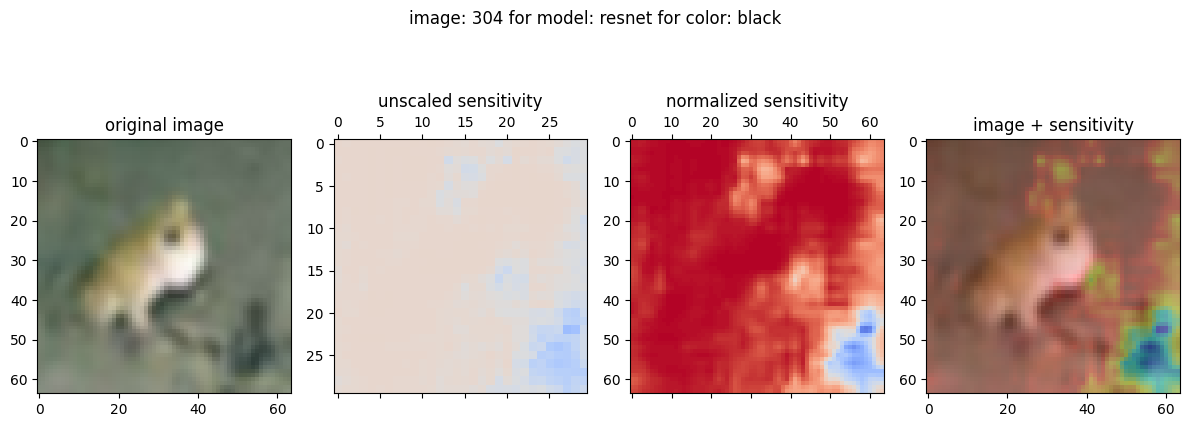

In [122]:
import math
from grad_cam.utils.image import show_cam_on_image
import cv2

# select test image
image_nr_list = list(range(300, 305)) #[300]

# box_color = 1 # 0 for black, 0.5 for grey, 1 for white
box_width = 6
box_stride = 2
box_padding = 0

img_width = 64

should_show_occlusion_image = False

output_width = math.floor((img_width - box_width + box_stride + box_padding) / box_stride)
print(f"sensitivity output width: {output_width}")

def calculate_occlusion_sensitivity(name, model, image_nr, box_color, color_name):
    org_image, true_label = cifar10_dataset[image_nr]
    display_org_image = org_image.numpy().transpose((1, 2, 0))
    image = org_image.unsqueeze(0)

    model.eval()
    if name == "mlp":
        image = image.view(-1)
        with torch.no_grad():
            output = model(image)
        probabilities = torch.nn.functional.softmax(output, dim=0)
    elif name == "resnet":
        # input_tensor = preprocess_image(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        with torch.no_grad():
            output = model(image).squeeze_()
        probabilities = torch.nn.functional.softmax(output, dim=0)
        true_label = probabilities.argmax()
    baseline_prob = probabilities[true_label]

    sensitivity = np.zeros((output_width, output_width))
    for k, i in enumerate(range(0 - box_padding, img_width - box_width + 1 + box_padding, box_stride)):
        for m, j in enumerate(range(0 - box_padding, img_width - box_width + 1 + box_padding, box_stride)):
            image, _ = cifar10_dataset[image_nr]
            i_index_list = list(range(max(i, 0), min(i + box_width, img_width)))
            j_index_list = list(range(max(j, 0), min(j + box_width, img_width)))
            for ii in i_index_list:
                for jj in j_index_list: 
                    image[:, ii, jj] = box_color

            if should_show_occlusion_image:
                # display image
                display_image = image.numpy().transpose((1, 2, 0))
                plt.imshow(display_image)
                plt.show()

            image = image.unsqueeze(0)
            if name == "mlp":
                image = image.view(-1)
                with torch.no_grad():
                    output = model(image)
            elif name == "resnet":
                # input_tensor = preprocess_image(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                with torch.no_grad():
                    output = model(image).squeeze_()
            else:
                print(f"unknown name: {name}")
            
            probabilities = torch.nn.functional.softmax(output, dim=0)
            sensitivity[k, m] = probabilities[true_label] - baseline_prob
            # print(f"sensitivity[{k}, {m}] = {probabilities[true_label]:.4f} - {baseline_prob:.4f} = {sensitivity[k, m]:.4f}")

    negated_sensitivity = -sensitivity
    
    min_negated_sensitivity = negated_sensitivity.min()
    max_negated_sensitivity = negated_sensitivity.max()
    
    range_negated_sensitivity = max_negated_sensitivity - min_negated_sensitivity + 1e-10
    grayscale_sensitivity = (negated_sensitivity - min_negated_sensitivity) / range_negated_sensitivity
    grayscale_scaled_sensitivity = cv2.resize(grayscale_sensitivity, (64, 64))
    cam_image = show_cam_on_image(display_org_image, grayscale_scaled_sensitivity, use_rgb=True, image_weight=0.7)
    fig, axes = plt.subplots(1, 4, figsize=(12, 5))
    fig.suptitle(f"image: {image_nr} for model: {name} for color: {color_name}")
    axes[0].imshow(display_org_image)
    axes[0].set_title("original image")
    axes[1].matshow(negated_sensitivity, vmin=-1, vmax=1, cmap="coolwarm")
    axes[1].set_title("unscaled sensitivity")
    axes[2].matshow(grayscale_scaled_sensitivity, vmin=0, vmax=1, cmap="coolwarm")
    axes[2].set_title("normalized sensitivity")
    axes[3].imshow(cam_image)
    axes[3].set_title("image + sensitivity")
    plt.tight_layout()
    plt.show()

for image_nr in image_nr_list:
    print(f"image number: {image_nr}")
    
    # MLP
    calculate_occlusion_sensitivity("mlp", model, image_nr, 0.0, "black")
    calculate_occlusion_sensitivity("mlp", model, image_nr, 0.5, "grey")
    calculate_occlusion_sensitivity("mlp", model, image_nr, 1.0, "white")

    # ResNet
    calculate_occlusion_sensitivity("resnet", resnet_model, image_nr, 0.0, "black")

    plt.show()